## Notebook description
* On the first part of the notebook you can see the flow we did to preprocess data with explanations about what we did.
* On the second part you can see the functions that we used for running the process A-Z (united the code to small functions).
* On the third part we present the base model that we chose.


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [ ]:
train_y = train['SalePrice']
train_X = train.copy().loc[:,train.columns != 'SalePrice']  

### Main functions

In [ ]:
def create_normalize_feature(df, feature, ordered_categories):
  weight = 1/(len(ordered_categories)-1)
  for i in range(len(ordered_categories)):
    df[feature].replace(ordered_categories[i], round(weight*(i),3), 
                       inplace= True)

In [ ]:
def merge_categories_by_threshold(df, label, new_col_name, threshold):
  value_counts_label = df.value_counts(df[label])
  mask = (value_counts_label / value_counts_label.sum() * 100).lt(threshold)
  new_df = df.assign(new_label = 
                           np.where(df[label].isin(
                               value_counts_label[mask].index),
                                    'Other', df[label]))
  new_df.rename(columns={'new_label': new_col_name}, inplace=True)
  new_df.drop(columns = label, inplace=True)
  return new_df

# Handle Missing values

* At this part we will fill the nan values by treating each feature seperatly by it's properties. In addition we will the those features that are categorical to numeric.

* We decided to change the categorical features to numeric by given normalize values to them

In [ ]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

As we can see there are some variables with missing values. Let's check which variables has nan and need to handle.

In [ ]:
missing = train_X.isna().sum(axis=0)
missing = missing[missing>0]
missing.sort_values(ascending=False)

PoolQC          1453
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageFinish      81
GarageYrBlt       81
GarageType        81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

We want to find the best way to fili none in each variable, so we will explore every one of them seperately:

### PoolQC: Pool quality (1453 missing values)

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

We can check if the missing values are related to the non-missing column of PoolArea. Zero PoolArea means no pool at all.


In [ ]:
train_X[train_X.PoolQC.isna()].PoolArea.unique()

array([0])

* As we can see, all the rows with none value in "Pool quality" feature have 0 values in "Pool Area" feature. This means that all the houses that doesn't have pool quality value are houses without pool at all. 
* Also we can see that this feature is categorieze and we won't be able ot use it as is in linear regression. The categories are ordinal, so we can transom it to numerical values.
* We will replace all the none values of quality with 0.


In [ ]:
ordered_categories = ['Na', 'Fa', 'TA', 'Gd', 'Ex']
create_normalize_feature(train_X, 'PoolQC', ordered_categories)
train_X.PoolQC.fillna(0, inplace=True)

In [ ]:
train_X.PoolQC.value_counts()

0.00    1453
0.75       3
0.25       2
1.00       2
Name: PoolQC, dtype: int64

#### **Feature extraction option:**
In the futue we might consider to use an union feature:

$ Pool = PoolArea \cdot PoolQC$ 

With [0,1] normalization

## Fence: Fence quality (1179 missing values)

       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence


In [ ]:
train_X.Fence.fillna(0, inplace=True)
train_X.Fence = train_X.Fence.map({'GdPrv': 1, 'MnPrv': 0.75, 'GdWo': 0.5, 'MnWw': 0.25, 0:0})

## FireplaceQu: Fireplace quality (690 missing values)

Fireplaces: Number of fireplaces

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

Very similar to the pool feature. We can do the same here:

First we can check if the missing values are related to the non-missing column of PoolArea. Zero PoolArea means no pool at all.

In [ ]:
train_X.Fireplaces[train_X.FireplaceQu.isna()].unique()

array([0])

* As we can see, all the rows with none value in "Fireplaces" feature have 0 values in "Fireplace Quality" feature. This means that all the houses that doesn't have pool quality value are houses without pool at all. 
* Also we can see that this feature is categorieze and we won't be able ot use it as is in linear regression. The categories are ordinal, so we can transom it to numerical values.
* We will replace all the none values of quality with 0.


In [ ]:
ordered_categories = ['Na', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
create_normalize_feature(train_X, 'FireplaceQu', ordered_categories)
train_X.FireplaceQu.fillna(0, inplace=True)

#### **Feature extraction option**:
In the futue we might consider to use an union feature:

$ Fireplace = Fireplaces \cdot FireplaceQu$ 

With [0,1] normalization

## Garage features
There are some Garage feaures with missing values: 

GarageFinish, GarageYrBlt, GarageType, GarageQual, GarageCond

So we want to investigate them together with all the features that related to garage.

GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: Year garage was built
* If NaN - fill with zero
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
GarageCars: Size of garage in car capacity
* If NaN - fill with zero

GarageArea: Size of garage in square feet
* If NaN - fill with zero

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

* From our EDA we can see that GarageArea and GarageCars are high correlated, the GarageCars has better correlation with Y. 
So we might consider to remove GarageArea in the future.

In [ ]:
garage_columns = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 
                  'GarageArea', 'GarageQual', 'GarageCond']
garage = train_X[garage_columns]

garage_missing_columns = ['GarageType', 'GarageYrBlt', 'GarageFinish', 
                          'GarageQual', 'GarageCond']
garage[garage[garage_missing_columns].isna().all(axis=1)]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NaN,NaN,NaN,0,0,NaN,NaN
48,NaN,NaN,NaN,0,0,NaN,NaN
78,NaN,NaN,NaN,0,0,NaN,NaN
88,NaN,NaN,NaN,0,0,NaN,NaN
89,NaN,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...
1349,NaN,NaN,NaN,0,0,NaN,NaN
1407,NaN,NaN,NaN,0,0,NaN,NaN
1449,NaN,NaN,NaN,0,0,NaN,NaN
1450,NaN,NaN,NaN,0,0,NaN,NaN


* When we look on all the garage featurew we can see that on the places that we got nan values the garage area is 0 and the number of cars is 0, which means that there isn't garage at all and that's the reason for nan values.


#### GarageFinish, GarageQual, GarageCond
As we can see it has an ordinal categories so we can create a normalize numeric feature and on samples without garage fill nan as 0.

In [ ]:
ordered_categories = ['Na', 'Unf', 'RFn', 'Fin']
create_normalize_feature(train_X, 'GarageFinish', ordered_categories)
train_X.GarageFinish.fillna(0, inplace=True)

In [ ]:
ordered_categories = ['Na', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
create_normalize_feature(train_X, 'GarageQual', ordered_categories)
train_X.GarageQual.fillna(0, inplace=True)

In [ ]:
create_normalize_feature(train_X, 'GarageCond', ordered_categories)
train_X.GarageCond.fillna(0, inplace=True)

#### GarageYrBlt

* If there are nan values - we will fill them with zero.

In [ ]:
train_X.GarageYrBlt.fillna(0, inplace=True)

#### GarageType
from the EDA we can see that when we have a garage the sale price is higher so we can encode this feature to 1/0 valuse and the meaning of the feature will be if there is garage or not.

In [ ]:
train_X.loc[train_X['GarageType'].notnull(), 'GarageType'] = 1
train_X.GarageType.fillna(0, inplace=True)
train_X.rename(columns={'GarageType':'Garage'}, inplace=True)

## LotFrontage: Linear feet of street connected to property (259 missing)

There is not a lot of information about this feature but as seen in the EDA, the density of this feature is very centered around the mean with low std. This brings us to the conclusion that a fillna with mean will be the best approximation.

In [ ]:
train_X.LotFrontage.fillna(train_X.LotFrontage.mean(), inplace=True)

## Basement features (38, 37 missing)

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches)
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

In [ ]:
basement_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                    'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 
                    'TotalBsmtSF']
basement = train_X[basement_columns]

basement_missing_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 
                            'BsmtFinType1', 'BsmtFinType2']
basement[basement[basement_missing_columns].isna().all(axis=1)]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0,0
342,NaN,NaN,NaN,NaN,0,NaN,0,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0,0
371,NaN,NaN,NaN,NaN,0,NaN,0,0,0


#### BsmtQual + BsmtCond + BsmtExposure + BsmtFinType1 + BsmtFinType2

* When we look on all the basement featurew we can see that on the places that we got nan values the TotalBsmtSF (Total square feet of basement area) is 0 which means that there isn't basement at all and that's the reason for nan values.

* As we can see it has an ordinal categories so we can create a normalize numeric feature and on samples without garage fill nan as 0.

In [ ]:
ordered_categories = ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']
create_normalize_feature(train_X, 'BsmtQual', ordered_categories)
train_X.BsmtQual.fillna(0, inplace=True)

In [ ]:
create_normalize_feature(train_X, 'BsmtCond', ordered_categories)
train_X.BsmtCond.fillna(0, inplace=True)

In [ ]:
ordered_categories = ['NA','No', 'Mn', 'Av', 'Gd']
create_normalize_feature(train_X, 'BsmtExposure', ordered_categories)
train_X.BsmtExposure.fillna(0, inplace=True)

In [ ]:
ordered_categories = ['NA','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
create_normalize_feature(train_X, 'BsmtFinType1', ordered_categories)
train_X.BsmtFinType1.fillna(0, inplace=True)

In [ ]:
create_normalize_feature(train_X, 'BsmtFinType2', ordered_categories)
train_X.BsmtFinType2.fillna(0, inplace=True)

## MasVnrArea, MasVnrType (8 missing)

In [ ]:
vnr_columns = ['MasVnrArea', 'MasVnrType']
veneer = train_X[vnr_columns]

veneer[veneer.isna().all(axis=1)]

,MasVnrArea,MasVnrType
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


* When we check those columns we can see that MasVnrArea is nan on the same places as MasVnrType. The meaning of MasVnrType= nan is  that there isn't veneer at all.
So we can replace the nan values in MasVnrArea with 0 value which means that the veneer area is 0.

* In addition from the EDA we can see that when we have a veneer the sale price is higher so we can encode this feature to 1/0 valuse and the meaning of the feature will be if there is veneer or not.

In [ ]:
train_X.loc[train_X['MasVnrType'].notnull(), 'MasVnrType'] = 1
train_X.MasVnrType.fillna(0, inplace=True)
train_X['MasVnrType'][train_X.MasVnrArea == 0] = 0
train_X.rename(columns={'MasVnrType':'MasVnr'}, inplace=True)

train_X.MasVnrArea.fillna(0, inplace=True)

## Electrical (1 missing)

* There is 1 missing value. From the EDA we can see that over 90% of the values are 'SBrkr'. we fill the missing value with SBrkr.

* Because this category is ordinal we will convert it into numeric.

In [ ]:
train_X.Electrical.fillna('SBrkr', inplace=True)
ordered_categories = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr']
create_normalize_feature(train_X, 'Electrical', ordered_categories)

#Encoding categorical data

In [ ]:
des_obj = train_X.describe(include=[np.object]) 
des_obj.columns

Index(['Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC',
       'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

## Encoding ordinal categories
* First we want to encode all the categorial features that are ordinal.

In [ ]:
ordered_categories = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
features = ['HeatingQC', 'KitchenQual', 'ExterQual', 'ExterCond']

for feature in features:
  create_normalize_feature(train_X, feature, ordered_categories)

In [ ]:
ordered_categories = ['IR3', 'IR2', 'IR1', 'Reg']
create_normalize_feature(train_X, 'LotShape', ordered_categories)

ordered_categories = ['Low', 'HLS', 'Bnk', 'Lvl']
create_normalize_feature(train_X, 'LandContour', ordered_categories)

ordered_categories = ['Sev', 'Mod', 'Gtl']
create_normalize_feature(train_X, 'LandSlope', ordered_categories)

ordered_categories = ['Twnhs', 'TwnhsE', 'Duplex', '2fmCon', '1Fam']
create_normalize_feature(train_X, 'BldgType', ordered_categories)

ordered_categories = ['N', 'P', 'Y']
create_normalize_feature(train_X, 'PavedDrive', ordered_categories)

ordered_categories = ['ELO', 'NoSeWa', 'NoSewr', 'AllPub']
create_normalize_feature(train_X, 'Utilities', ordered_categories)

* Now we encode the boolean categorial features

In [ ]:
train_X.Street = train_X.Street.map({'Grvl': 1, 'Pave': 0})
train_X.CentralAir = train_X.CentralAir.map({'Y': 1, 'N': 0})

## Unit categories and defined the new features
* Those features has a lot of categories. We decided to union all the categories that are under < 5%.
afterward we saw we have 2 meaningfull categories in each feature so we encode everyone of the as boolean feature.

#### **RoofMatl**

* From the EDA we can see that all the categories except CompShg are below 5% of the values. We decided to convert this feature to represent if the roof is from CompShg or not.

In [ ]:
train_X = merge_categories_by_threshold(train_X, 'RoofMatl', 
                                        'RoofMatl_CompShg', 5)
train_X.RoofMatl_CompShg = train_X.RoofMatl_CompShg.map({'CompShg': 1, 
                                                         'Other': 0})

#### **Heating**

* From the EDA we can see that all the categories except GasA are below 5% of the values. We decided to convert this feature to represent if the heating is GasA or not.



In [ ]:
train_X = merge_categories_by_threshold(train_X, 'Heating', 
                                        'Heating_GasA', 5)
train_X.Heating_GasA = train_X.Heating_GasA.map({'GasA': 1, 'Other': 0})

#### **Functional**

* From the EDA we can see that all the categories except Typ (=Typical) are below 5% of the values. We decided to convert this feature to represent if the functional is Typical or not.

In case of NaN values, we assume Typical because of the high abundance of Typical (93% in the train data)

In [ ]:
train_X.fillna('Typ', inplace=True)
train_X = merge_categories_by_threshold(train_X, 'Functional', 
                                        'Functional_typical', 5)
train_X.Functional_typical = train_X.Functional_typical.map({'Typ': 1, 
                                                             'Other': 0})

#### **Condition 2**

* From the EDA we can see that all the categories except Norm (=Normal) are below 5% of the values. We decided to convert this feature to represent if the Condition2 is Normal or not.

In [ ]:
train_X = merge_categories_by_threshold(train_X, 'Condition2', 
                                        'Condition2_norm', 5)
train_X.Condition2_norm = train_X.Condition2_norm.map({'Norm': 1, 
                                                             'Other': 0})

## Unit categories and use onehot
* Those features has a lot of categories. We decided to union all the categories that are under < 5% and then we saw we have more then 2 categories so we used onehot to represent the feature

#### **RoofStyle**

In [ ]:
train_X = merge_categories_by_threshold(train_X, 'RoofStyle', 
                                        'RoofStyle_merged', 5)

#### **Foundation**

In [ ]:
train_X = merge_categories_by_threshold(train_X, 'Foundation', 
                                        'Foundation_merged', 5)

#### **SaleType**

In [ ]:
train_X = merge_categories_by_threshold(train_X, 'SaleType', 
                                        'SaleType_merged', 5)

#### **SaleCondition**

In [ ]:
train_X = merge_categories_by_threshold(train_X, 'SaleCondition', 
                                        'SaleCondition_merged', 5)

#### **HouseStyle**

In [ ]:
train_X = merge_categories_by_threshold(train_X, 'HouseStyle', 
                                        'HouseStyle_merged', 5)

#### **Exterior**

* When we checked the meaning of the columns we saw that they are both represent the Exterior covering on house. The Exterior1st represent the material and the second one another material (if exist) so we decided to combine it into one colum that represent the pairs of materials.

* When we checked the combine colum we saw there are some categories that are under the threshold we defined so we merge them together to "other" category.

* In the end we use onehot to encode the combined exterior feature

In [ ]:
train_X['Exterior_combined'] = train_X.apply(lambda x: x.Exterior1st + '_' + 
                                             x.Exterior2nd, axis=1)
train_X.drop(columns=['Exterior1st', 'Exterior2nd'], inplace=True)
train_X = merge_categories_by_threshold(train_X, 'Exterior_combined', 
                                        'Exterior_combined_merged', 5)
train_X.Exterior_combined_merged.value_counts()

VinylSd_VinylSd    502
Other              280
MetalSd_MetalSd    212
HdBoard_HdBoard    193
Wd Sdng_Wd Sdng    177
Plywood_Plywood     96
Name: Exterior_combined_merged, dtype: int64

#### **Neighborhood**
* When we checked the combine colum we saw there are some categories that are under the threshold we defined, so we merge them to "other" category.

* In the end we used onehot to encode the combined neighborhood feature

In [ ]:
train_X = merge_categories_by_threshold(train_X, 'Neighborhood', 
                                        'Neighborhood_merged', 5)

In [ ]:
# One-hot encoding with pd.get_dummies
onehot_columns = ['RoofStyle_merged', 'Foundation_merged', 'SaleType_merged', 
           'SaleCondition_merged', 'Exterior_combined_merged', 
           'HouseStyle_merged', 'Neighborhood_merged']
data = pd.get_dummies(train_X, prefix=onehot_columns, columns=onehot_columns)

## Remove categorial

* There are some features we decide to remove from diffrent reasons:
 - **LotConfig, Condition1, MoSold**- we decided to remove those features because it's correlation with Y is very low (below 0.2) 

 - **Neighborhood_merged_NWAmes**- we decided to remove this feature because the maning of getting 0 in all the other categories of neighborhood is that the house is in this neighborhood so it doesn't contribute us.

In [ ]:
data.info()

In [ ]:
columns = ['LotConfig', 'Condition1', 'MoSold','Neighborhood_merged_NWAmes']
data.drop(columns = columns, inplace=True)

In [ ]:
data.set_index(['Id'], inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 98 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   MSSubClass                                1460 non-null   int64  
 1   LotFrontage                               1460 non-null   float64
 2   LotArea                                   1460 non-null   int64  
 3   Street                                    1460 non-null   int64  
 4   LotShape                                  1460 non-null   float64
 5   LandContour                               1460 non-null   float64
 6   Utilities                                 1460 non-null   float64
 7   LandSlope                                 1460 non-null   float64
 8   BldgType                                  1460 non-null   float64
 9   OverallQual                               1460 non-null   int64  
 10  OverallCond                         

## Using Y-log
* We saw in the EDA that the y is closer to log_norm distribution then to norm, so we decided to transform the Y

In [ ]:
y_train_log = np.log1p(train_y)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


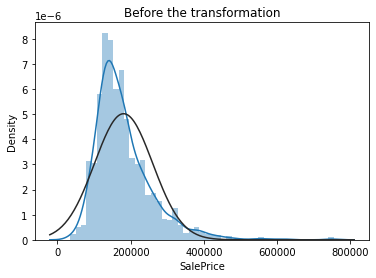

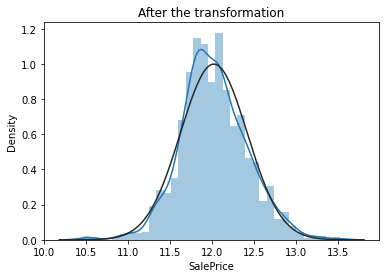

In [ ]:
from scipy.stats import norm
plt.figure();
sns.distplot(train_y , fit=norm);
plt.title('Before the transformation');

plt.figure();
plt.title('After the transformation');
sns.distplot(y_train_log , fit=norm);


# Preprocess A-Z

In [ ]:
def garage_features(df):
  df.loc[df['GarageType'].notnull(), 'GarageType'] = 1
  df.GarageType.fillna(0, inplace=True)
  df.rename(columns={'GarageType':'Garage'}, inplace=True)

def lot_frontage_feature(df):
  df.LotFrontage.fillna(df.LotFrontage.mean(), inplace=True)

def veneer_features(df):
  df.loc[df['MasVnrType'].notnull(), 'MasVnrType'] = 1
  df.MasVnrType.fillna(0, inplace=True)
  df['MasVnrType'][df.MasVnrArea == 0] = 0
  df.rename(columns={'MasVnrType':'MasVnr'}, inplace=True)
  df.MasVnrArea.fillna(0, inplace=True)

def functional_feature(df):
  df.Functional.fillna('Typ', inplace=True)

def electrical_feature(df):
  df.Electrical.fillna('SBrkr', inplace=True)
  ordered_categories = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr']
  create_normalize_feature(df, 'Electrical', ordered_categories)

def exterior_feature(df):
  df.Exterior1st.fillna('None', inplace=True)
  df.Exterior2nd.fillna('None', inplace=True)
  df['Exterior_combined'] = df.apply(lambda x: x.Exterior1st + '_' + 
                                             x.Exterior2nd, axis=1)
  df.drop(columns=['Exterior1st', 'Exterior2nd'], inplace=True)

In [ ]:
def fillna_continues_features(df, continues_features):
  for feature in continues_features:
    df.loc[np.isnan(df[feature]), feature] = 0

def encoding_ordinal_categories(df, categorial_dict):
  for feature, ordered_categories in categorial_dict.items():
    create_normalize_feature(df, feature, ordered_categories)
    df.loc[np.isnan(df[feature]), feature] = 0

def special_categories_treatment(df):
  garage_features(df)
  functional_feature(df)
  lot_frontage_feature(df)
  veneer_features(df)
  electrical_feature(df)
  exterior_feature(df)

def remove_categorical_features(df, columns):
    df_columns = df.columns
    for feature in columns:
        if feature in df_columns:
            df.drop(columns = [feature], inplace=True)

def merge_categories(df, merged_features_dict, threshold):
  for feature, new_feature in merged_features_dict.items():
    df = merge_categories_by_threshold(df, feature, new_feature, threshold)
  return df

def unicode_features(df, unicode_dict):
  for feature, new_unicode_dict in unicode_dict.items():
    df[feature] = df[feature].map(new_unicode_dict) 

def create_onehot_features(df, onehot_columns):
  data = pd.get_dummies(df, prefix=onehot_columns, columns=onehot_columns)
  return data

In [ ]:
def preprocessing(df, continues_features, category_ordered, remove_columns, 
                  merged_features_dict, unicode_features_dict, onehot_columns):
  fillna_continues_features(df, continues_features)
  encoding_ordinal_categories(df, category_ordered)
  special_categories_treatment(df)
  df = merge_categories(df, merged_features_dict, 5)
  unicode_features(df, unicode_features_dict)
  data = create_onehot_features(df, onehot_columns)
  remove_categorical_features(data, remove_columns)
  data.set_index(['Id'], inplace=True)
  return data

In [ ]:
continues_features = ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
                      'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt']

category_ordered = {'PoolQC': ['Na', 'Fa', 'TA', 'Gd', 'Ex'],
                    'Fence': ['Na', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
                    'FireplaceQu': ['Na', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                    'GarageFinish': ['Na', 'Unf', 'RFn', 'Fin'],
                    'GarageQual': ['Na', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                    'GarageCond': ['Na', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                    'BsmtQual': ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex'],
                    'BsmtCond': ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex'],
                    'BsmtExposure': ['NA','No', 'Mn', 'Av', 'Gd'],
                    'BsmtFinType1': ['NA','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                    'BsmtFinType2': ['NA','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
                    'LandContour': ['Low', 'HLS', 'Bnk', 'Lvl'],
                    'LandSlope': ['Sev', 'Mod', 'Gtl'],
                    'BldgType': ['Twnhs', 'TwnhsE', 'Duplex', '2fmCon', '1Fam'],
                    'PavedDrive': ['N', 'P', 'Y'],
                    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub']}
            
merged_features_dict = {'RoofMatl': 'RoofMatl_CompShg', 
                        'Heating': 'Heating_GasA',
                        'Functional': 'Functional_typical',
                        'RoofStyle': 'RoofStyle_merged',
                        'Foundation': 'Foundation_merged',
                        'SaleType': 'SaleType_merged',
                        'SaleCondition': 'SaleCondition_merged',
                        'Condition2': 'Condition2_norm',
                        'HouseStyle': 'HouseStyle_merged',
                        'Neighborhood': 'Neighborhood_merged',
                        'Exterior_combined': 'Exterior_combined_merged'}
                                            
unicode_features_dict = {'Street': {'Grvl': 1, 'Pave': 0},
                          'CentralAir': {'Y': 1, 'N': 0},
                          'RoofMatl_CompShg': {'CompShg': 1, 'Other': 0},
                          'Heating_GasA': {'GasA': 1, 'Other': 0},
                          'Functional_typical': {'Typ': 1, 'Other': 0},
                          'Condition2_norm': {'Norm': 1, 'Other': 0}}

onehot_columns = ['RoofStyle_merged', 'Foundation_merged', 'SaleType_merged', 
                  'SaleCondition_merged', 'Exterior_combined_merged',
                  'HouseStyle_merged', 'Neighborhood_merged']

remove_columns = ['LotConfig', 'Condition1', 'MoSold', 'Neighborhood_merged_NWAmes']

# Basic model- linear regression after preprocessing

* This model represent the current results after we finished the preprocessing without adding any other changes. 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

train_y = train['SalePrice']
train_X = train.copy().loc[:,train.columns != 'SalePrice']  

train_X = preprocessing(train_X, continues_features, category_ordered, 
                        remove_columns, merged_features_dict, 
                        unicode_features_dict, onehot_columns)

In [ ]:
# Transform target values from log-normal to normal
y_train_log = np.log1p(train_y)

est = LinearRegression().fit(train_X, y_train_log)
y_pred = est.predict(train_X)
y_pred_final = np.expm1(y_pred)
np.sqrt(mean_squared_log_error(train_y, y_pred_final))

0.12822002934702423

In [ ]:
 from sklearn.model_selection import cross_val_score
 from sklearn.linear_model import LinearRegression

 clf = LinearRegression()
 print(cross_val_score(clf, train_X, y_train_log, cv=5))

[0.88743536 0.85691251 0.8915022  0.88653558 0.77064231]


In [ ]:
test = pd.read_csv('test.csv')
test_X = preprocessing(test, continues_features, category_ordered, remove_columns, 
                  merged_features_dict, unicode_features_dict, onehot_columns)

y_pred = est.predict(test_X)
# Transform the target values back 
y_pred_final = np.expm1(y_pred)
submission = pd.DataFrame({'Id':test.Id, 'Predicted': y_pred_final})

In [ ]:
submission.to_csv('submission.csv', index=False)